In [20]:
import os
import pickle
import keras
import time

import numpy as np
import pandas as pd
import seaborn as sn
import random as rn
import tensorflow as tf
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.models import model_from_json
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.optimizers import Adam

from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers.core import Dense, Activation
from sklearn.model_selection import GridSearchCV

from keras.models import load_model

In [21]:
def MLP_print_cmx(y_true, y_pred):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
    plt.figure(figsize = (12,8))
    sn.heatmap(df_cmx, annot=True, fmt="d") ### ヒートマップの表示仕様
    plt.title("Confusion Matrix")
    plt.xlabel("predict_classes")
    plt.ylabel("true_classes")
    print('スポーツ : 0 / IT : 1 / 映画 : 2 / ライフ : 3')
    plt.show()

# dmpv

In [22]:
def MLP_dmpv(x_test, x_train, y_test, y_train, z_test, z_train, x_size, p):
    MLP_model = Sequential()
    # MLPモデル構造を定義 --- (*5)
    MLP_model.add(Dense(128, activation='relu', input_shape=(x_size,)))
    MLP_model.add(Dropout(0.2))
    MLP_model.add(Dense(128, activation='relu'))
    MLP_model.add(Dropout(0.2))
    MLP_model.add(Dense(128, activation='relu'))
    MLP_model.add(Dropout(0.2))
    MLP_model.add(Dense(nb_classes, activation='softmax'))

    # モデルをコンパイル --- (*6)
    MLP_model.compile(
        loss='categorical_crossentropy',
        optimizer=RMSprop(),
        metrics=['accuracy'])
    
    t1 = time.time()                 #　開始
    # 学習を実行 --- (*7)
    hist = MLP_model.fit(x_train, y_train,
              batch_size=128,
              epochs=50,
              verbose=1,
              validation_data=(x_test, y_test))
    t2 = time.time()                #　終了
    
   # モデルの保存
    MLP_model.save('./model/dmpv_model_'+str(p)+'.hdf5')
    
    # モデルのロード
    model = load_model('./model/dmpv_model_'+str(p)+'.hdf5')
    #  混同行列
    predict_classes = model.predict_classes(x_test[1:10000]) ### 予測したラベルを取得
    true_classes = np.argmax(y_test[1:10000], 1) ### 実際のラベルを取得

    # 評価する ---(*8)
    score = model.evaluate(x_test, y_test, verbose=1)
    print('\n')
    print("正解率=", score[1], 'loss=', score[0])

    #  適応率, 再現率, F値
    rep = metrics.classification_report(true_classes, predict_classes)
    print(rep)

    # 学習の様子をグラフへ描画 --- (*10)
    # Accuracy
    plt.figure(figsize=(20, 5)) # figureの縦横の大きさ
    plt.subplot(1,2,1)
    plt.plot(hist.history['acc'])
    plt.plot(hist.history['val_acc'])
    plt.title('Accuracy')
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Loss')
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid()

    MLP_print_cmx(true_classes, predict_classes)

    # 経過時間を表示
    elapsed_time = t2-t1
    print(f"処理時間：{elapsed_time}"+"[s]")

    LABELS = ["スポーツ", "IT", "映画", "ライフ"]
    A=[]
    B=[]
    C=[]
    D=[]
    for i, j, k in zip(x_test, y_test, z_test):
        pre = MLP_model.predict(np.array([i]))[0]
        n = pre.argmax()
        l=np.where(j==1.0)
        if LABELS[n]!=LABELS[l[0][0]]:
            A.append(LABELS[n])
            B.append(pre[n])
            C.append(LABELS[l[0][0]])
            D.append(k)

    df=pd.DataFrame({'text':D,
                                     'true_label':C, 
                                    'pre_label':A,
                                    'prediction':B}
                                   )

    #     df.to_excel('Excel/TF-IDF_MLP_'+str(p)+'.xlsx', encoding='UTF-16')
    display(df)

In [23]:
# データのロード
data_c=pickle.load(open('/Users/Baron/Document/text_mining/Data/pickle/Doc2Vec/Body/d2v_body_dmpv.pickle', "rb"))

z_c = data_c[0]   # 内容
y_c = data_c[1]   # ラベル
x_c = data_c[2]   # 特徴量

kf = KFold(n_splits=5, shuffle=True, random_state=0)
nb_classes = 4
# ラベルデータをone-hotベクトルに直す --- (*3)
y_c = keras.utils.np_utils.to_categorical(y_c, nb_classes)

# データの次元数
x_size = x_c[0].shape[0]
y_size = y_c[0].shape[0]

A_index_c=[]
B_index_c=[]
C_index_c=[]
D_index_c=[]
E_index_c=[]
F_index_c=[]

# 交差検証
for train, test in kf.split(x_c):
    A_c=np.empty((0,x_size), int)
    B_c=np.empty((0,x_size), int)
    C_c=np.empty((0,y_size), int)
    D_c=np.empty((0,y_size), int)
    E_c = []
    F_c = []
    for i in test:
        A_c = np.append(A_c, [x_c[i]], axis=0)           # x_test
        C_c = np.append(C_c, [y_c[i]], axis=0)           # y_test
        E_c.append(z_c[i])                                     # z_test
    A_index_c.append(A_c)
    C_index_c.append(C_c)
    E_index_c.append(E_c)
    for j in train:
        B_c = np.append(B_c, [x_c[j]], axis=0)            # x_train
        D_c = np.append(D_c, [y_c[j]], axis=0)           # y_train
        F_c.append(z_c[j])                                      # z_train
    B_index_c.append(B_c)
    D_index_c.append(D_c)
    F_index_c.append(F_c)

Train on 2806 samples, validate on 702 samples
Epoch 1/50
2806/2806 [==============================] - 4s 1ms/step - loss: 0.6061 - acc: 0.8133 - val_loss: 0.1605 - val_acc: 0.9544
Epoch 2/50
2806/2806 [==============================] - 0s 57us/step - loss: 0.1413 - acc: 0.9576 - val_loss: 0.1249 - val_acc: 0.9615
Epoch 3/50
2806/2806 [==============================] - 0s 48us/step - loss: 0.0900 - acc: 0.9726 - val_loss: 0.1278 - val_acc: 0.9573
Epoch 4/50
2806/2806 [==============================] - 0s 49us/step - loss: 0.0747 - acc: 0.9768 - val_loss: 0.1104 - val_acc: 0.9615
Epoch 5/50
2806/2806 [==============================] - 0s 48us/step - loss: 0.0652 - acc: 0.9793 - val_loss: 0.1187 - val_acc: 0.9615
Epoch 6/50
2806/2806 [==============================] - 0s 53us/step - loss: 0.0499 - acc: 0.9836 - val_loss: 0.1232 - val_acc: 0.9544
Epoch 7/50
2806/2806 [==============================] - 0s 57us/step - loss: 0.0382 - acc: 0.9872 - val_loss: 0.1327 - val_acc: 0.9644
Epoch 8/5

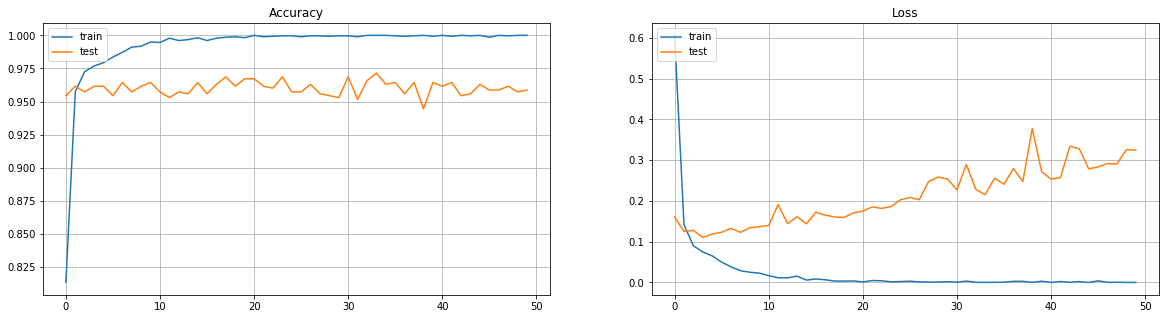

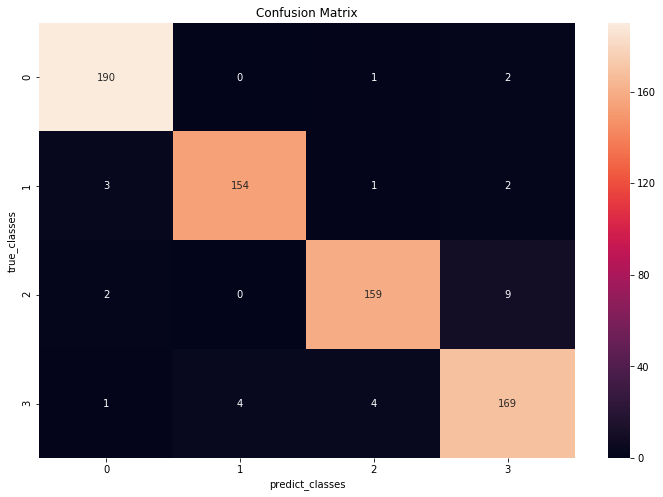

処理時間：12.628116846084595[s]


,text,true_label,pre_label,prediction
0,【Sports Watch】シンクロ美人姉妹の驚くべき特技とは？,スポーツ,ライフ,0.646202
1,【Sports Watch／競馬】 あの名物珍名馬主・今年は役職シリーズ？,スポーツ,ライフ,0.991234
2,【Sports Watch／競馬】 迷走中!? 『うまプロ！』は何がしたいのか—,スポーツ,映画,0.999465
3,スマホ購入でゲーム初体験！ MMD研究所「マートフォン所有者の接触頻度に関する実態調査」,IT,ライフ,0.729564
4,今年の夏は湘南とお台場へGo！ ニコニコ神社、夏の出張はお台場と海の家,IT,映画,0.999962
5,個人スポンサー2万人達成！ロンドン五輪マラソン代表選手の藤原新選手,IT,スポーツ,0.999989
6,日本最大級のショッピングポータルがオープン！「イオンスクエア」が凄い理由,IT,ライフ,0.992614
7,本日のGoogleロゴはやり投 Googleロゴがスポーツ関連画像に変化第七弾,IT,スポーツ,0.999837
8,本日のGoogleロゴはテーブルテニス Googleロゴがスポーツ関連画像に変化第四弾,IT,スポーツ,1.000000
9,“FBI行動分析課”に学べ！ 『クリミナル・マインド』流トラブルを生き抜くビジネス術,映画,ライフ,0.999999


In [24]:
MLP_dmpv(A_index_c[0], B_index_c[0], C_index_c[0], D_index_c[0], E_index_c[0], F_index_c[0], x_size, p=0)

Train on 2806 samples, validate on 702 samples
Epoch 1/50
2806/2806 [==============================] - 5s 2ms/step - loss: 0.6522 - acc: 0.8076 - val_loss: 0.0990 - val_acc: 0.9758
Epoch 2/50
2806/2806 [==============================] - 0s 68us/step - loss: 0.1592 - acc: 0.9537 - val_loss: 0.0607 - val_acc: 0.9801
Epoch 3/50
2806/2806 [==============================] - 0s 63us/step - loss: 0.1124 - acc: 0.9654 - val_loss: 0.0650 - val_acc: 0.9772
Epoch 4/50
2806/2806 [==============================] - 0s 56us/step - loss: 0.0938 - acc: 0.9665 - val_loss: 0.0692 - val_acc: 0.9729
Epoch 5/50
2806/2806 [==============================] - 0s 65us/step - loss: 0.0717 - acc: 0.9751 - val_loss: 0.0575 - val_acc: 0.9829
Epoch 6/50
2806/2806 [==============================] - 0s 52us/step - loss: 0.0571 - acc: 0.9818 - val_loss: 0.0605 - val_acc: 0.9772
Epoch 7/50
2806/2806 [==============================] - 0s 42us/step - loss: 0.0428 - acc: 0.9868 - val_loss: 0.0712 - val_acc: 0.9758
Epoch 8/5

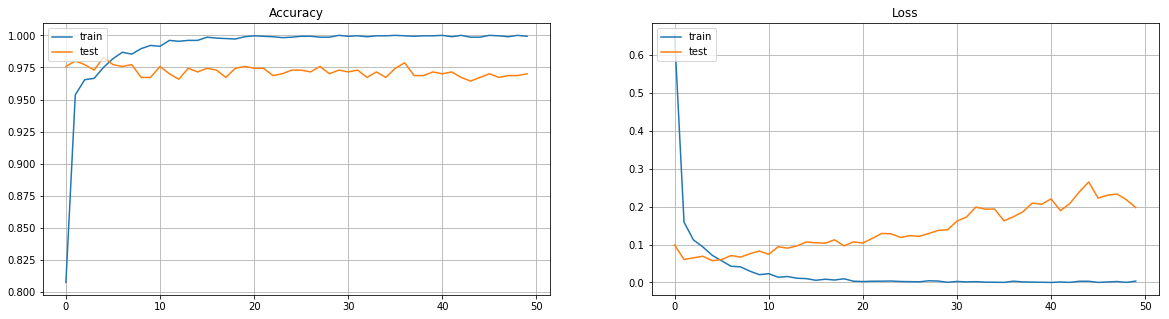

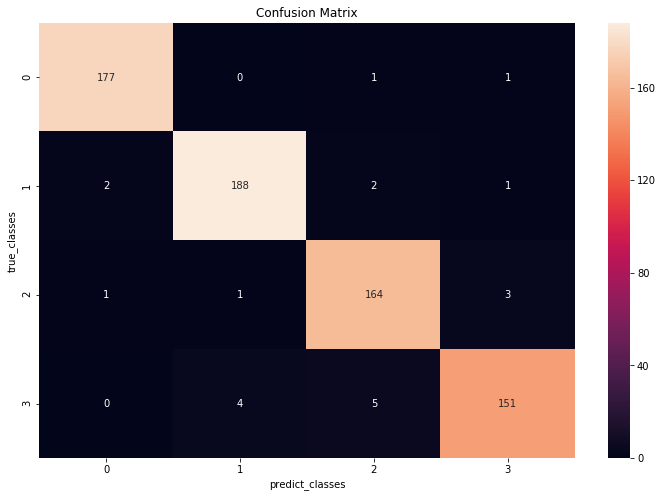

処理時間：14.158591032028198[s]


,text,true_label,pre_label,prediction
0,イギリス中が熱狂したキュートすぎる陸上界の女王,スポーツ,映画,0.984103
1,長谷部誠、印税を全額被災地に寄付,スポーツ,ライフ,0.777732
2,パチンコ店でも通話がクリア！電話としてのau最新スマホの音声を徹底チェック,IT,スポーツ,0.756666
3,全国21店舗で配信開始！ ドスパラが9月より店内放送型情報番組を開始,IT,映画,0.990003
4,夏と言えば朝顔！ 小学生時代を思い起こさせるアサガオ観察日記ツイート,IT,ライフ,0.999996
5,懐かしのヒーローが続々！ 名アニメーターが描くヒーローイラストが話題に,IT,映画,0.991445
6,斬新なアート表現と生命力！フィリピンの「今」が見られる「The Hope & The D...,IT,スポーツ,0.999987
7,【いちおう妖ヶ劇場】第5話：妖怪集まりゃ、メジャーなんて目じゃーないの巻,映画,スポーツ,0.999682
8,原発が日本にとって必要なのか、そうではないのか問う,映画,IT,0.999995
9,恋人に会うために脱獄した、一途な“天才犯罪者”,映画,ライフ,0.881392


In [25]:
MLP_dmpv(A_index_c[1], B_index_c[1], C_index_c[1], D_index_c[1], E_index_c[1], F_index_c[1], x_size, p=1)

Train on 2806 samples, validate on 702 samples
Epoch 1/50
2806/2806 [==============================] - 4s 2ms/step - loss: 0.6321 - acc: 0.7965 - val_loss: 0.1858 - val_acc: 0.9501
Epoch 2/50
2806/2806 [==============================] - 0s 55us/step - loss: 0.1405 - acc: 0.9530 - val_loss: 0.1239 - val_acc: 0.9601
Epoch 3/50
2806/2806 [==============================] - 0s 92us/step - loss: 0.0983 - acc: 0.9683 - val_loss: 0.1228 - val_acc: 0.9630
Epoch 4/50
2806/2806 [==============================] - 0s 66us/step - loss: 0.0781 - acc: 0.9708 - val_loss: 0.1232 - val_acc: 0.9644
Epoch 5/50
2806/2806 [==============================] - 0s 71us/step - loss: 0.0621 - acc: 0.9822 - val_loss: 0.1211 - val_acc: 0.9672
Epoch 6/50
2806/2806 [==============================] - 0s 91us/step - loss: 0.0541 - acc: 0.9797 - val_loss: 0.1206 - val_acc: 0.9687
Epoch 7/50
2806/2806 [==============================] - 0s 78us/step - loss: 0.0412 - acc: 0.9865 - val_loss: 0.1269 - val_acc: 0.9687
Epoch 8/5

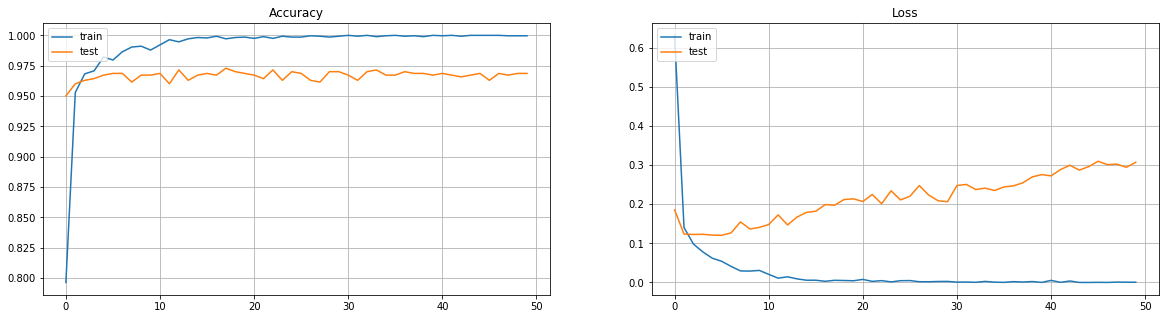

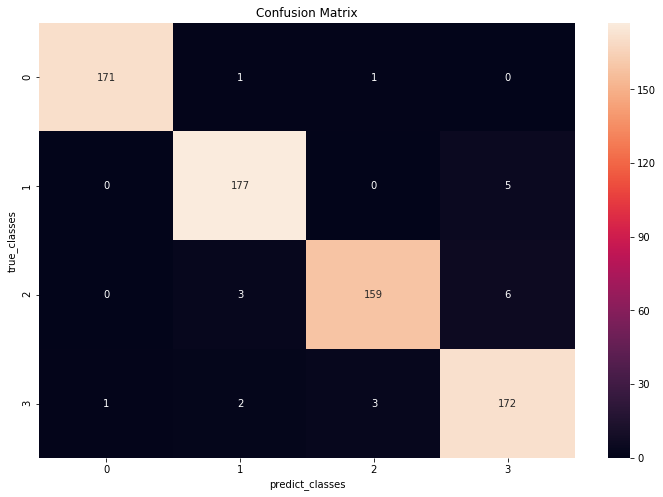

処理時間：19.23619294166565[s]


,text,true_label,pre_label,prediction
0,「これは可愛い」 佐々木希の後継、ブレイク必至の新EUROガール,スポーツ,映画,0.999971
1,【Sports Watch／競馬】 配当上乗せの「JRAプレミアムレース」ではこの馬券を買え！,スポーツ,IT,1.000000
2,あえてFermiを狙う！ KeplerではなくFermiで幸せになる！,IT,ライフ,0.980198
3,カワイイは正義！ おかもとまりさんのカワイすぎる顔真似メイキングが反則過ぎる,IT,ライフ,0.998891
4,大人気Ultrabookが作れる！ 親子で体験!! デル パソコン組み立て教室5回目...,IT,ライフ,0.999860
5,愛される英王子 裸で敬礼！ ハリー英国王子に対する英国軍人の大いなる愛,IT,ライフ,0.772192
6,細かな違いや使用感がわかる！ありそうでなかった白髪染め体験記サイト,IT,ライフ,1.000000
7,『バック・トゥ・ザ・フューチャー』に登場するデロリアン、世界30台限定で販売,映画,IT,1.000000
8,【編集部的映画批評】冴えない中年がチョイ悪オヤジに変身、人の数だけ異なる“幸せ”の形,映画,ライフ,0.999447
9,【編集部的映画批評】最高にポップな監禁拷問地獄へようこそ 『ラブド・ワンズ』,映画,ライフ,1.000000


In [26]:
MLP_dmpv(A_index_c[2], B_index_c[2], C_index_c[2], D_index_c[2], E_index_c[2], F_index_c[2], x_size, p=2)

Train on 2807 samples, validate on 701 samples
Epoch 1/50
2807/2807 [==============================] - 4s 2ms/step - loss: 0.5850 - acc: 0.8126 - val_loss: 0.1399 - val_acc: 0.9615
Epoch 2/50
2807/2807 [==============================] - 0s 89us/step - loss: 0.1448 - acc: 0.9519 - val_loss: 0.1117 - val_acc: 0.9601
Epoch 3/50
2807/2807 [==============================] - 0s 67us/step - loss: 0.1037 - acc: 0.9662 - val_loss: 0.1014 - val_acc: 0.9686
Epoch 4/50
2807/2807 [==============================] - 0s 53us/step - loss: 0.0808 - acc: 0.9743 - val_loss: 0.1184 - val_acc: 0.9658
Epoch 5/50
2807/2807 [==============================] - 0s 46us/step - loss: 0.0655 - acc: 0.9790 - val_loss: 0.0939 - val_acc: 0.9729
Epoch 6/50
2807/2807 [==============================] - 0s 46us/step - loss: 0.0521 - acc: 0.9825 - val_loss: 0.1078 - val_acc: 0.9658
Epoch 7/50
2807/2807 [==============================] - 0s 71us/step - loss: 0.0377 - acc: 0.9890 - val_loss: 0.1103 - val_acc: 0.9729
Epoch 8/5

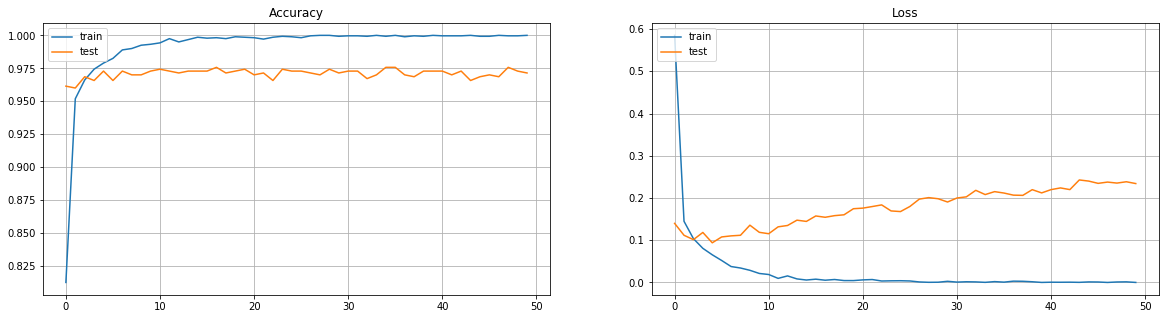

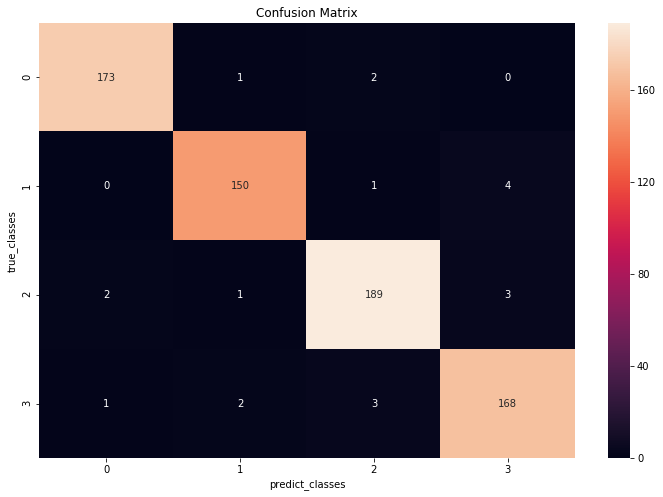

処理時間：17.012173175811768[s]


,text,true_label,pre_label,prediction
0,【Sports Watch】W杯ツアー業者が音信不通、被害額は1500万円超!?,スポーツ,IT,1.000000
1,【Sports Watch】長谷川穂積、最愛の母が死去 “もし一つだけ願いが叶うなら・・・”,スポーツ,映画,0.999829
2,開会式は「五輪のマークが出てきて、それがとんでもないことになる」!?,スポーツ,映画,0.526014
3,117万2132件の動画中最高の1本！ニコニコ動画「第4回動画アワード」グランプリ作品決定,IT,映画,0.931137
4,何これやばい！ウマそう！ ホントに学食？ 最近の学食は驚きの豪華メニュー,IT,ライフ,1.000000
5,同じ趣味の人を紹介し合おう Facebookで広げる友達の輪【知っ得！虎の巻】,IT,ライフ,1.000000
6,夏のボーナス金額は増！ ただし商品の購入に充てる割合は大幅減,IT,ライフ,1.000000
7,次世代22nmプロセッサー対応「Z77X-UD5H」マザーボードの魅力をさぐる,IT,ライフ,0.614607
8,“女子校の王子”と“男子校の姫”が禁断の恋に,映画,ライフ,0.930711
9,“日本版EMINEM”ヒップホップ界の頂点が問題作のイメージ楽曲で参戦,映画,IT,0.756420


In [27]:
MLP_dmpv(A_index_c[3], B_index_c[3], C_index_c[3], D_index_c[3], E_index_c[3], F_index_c[3], x_size, p=3)

Train on 2807 samples, validate on 701 samples
Epoch 1/50
2807/2807 [==============================] - 4s 1ms/step - loss: 0.5931 - acc: 0.8258 - val_loss: 0.1539 - val_acc: 0.9515
Epoch 2/50
2807/2807 [==============================] - 0s 65us/step - loss: 0.1518 - acc: 0.9505 - val_loss: 0.0872 - val_acc: 0.9743
Epoch 3/50
2807/2807 [==============================] - 0s 57us/step - loss: 0.1029 - acc: 0.9662 - val_loss: 0.0845 - val_acc: 0.9729
Epoch 4/50
2807/2807 [==============================] - 0s 75us/step - loss: 0.0861 - acc: 0.9736 - val_loss: 0.0884 - val_acc: 0.9743
Epoch 5/50
2807/2807 [==============================] - ETA: 0s - loss: 0.0713 - acc: 0.975 - 0s 58us/step - loss: 0.0743 - acc: 0.9736 - val_loss: 0.0802 - val_acc: 0.9743
Epoch 6/50
2807/2807 [==============================] - 0s 60us/step - loss: 0.0611 - acc: 0.9811 - val_loss: 0.0808 - val_acc: 0.9743
Epoch 7/50
2807/2807 [==============================] - 0s 80us/step - loss: 0.0434 - acc: 0.9861 - val_lo

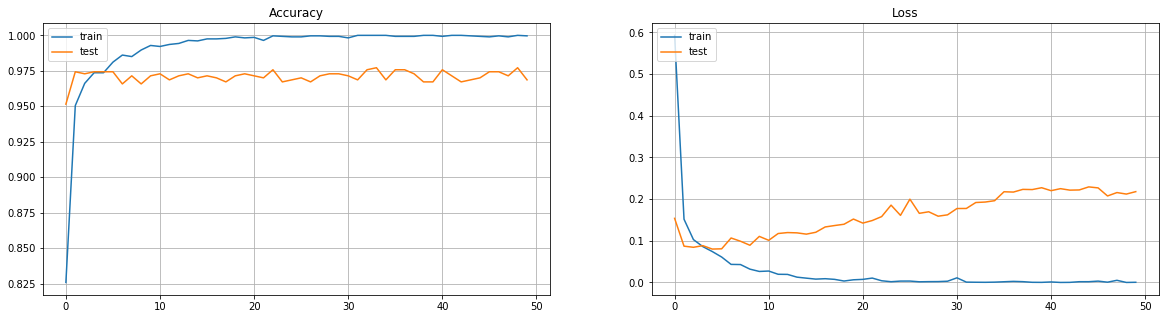

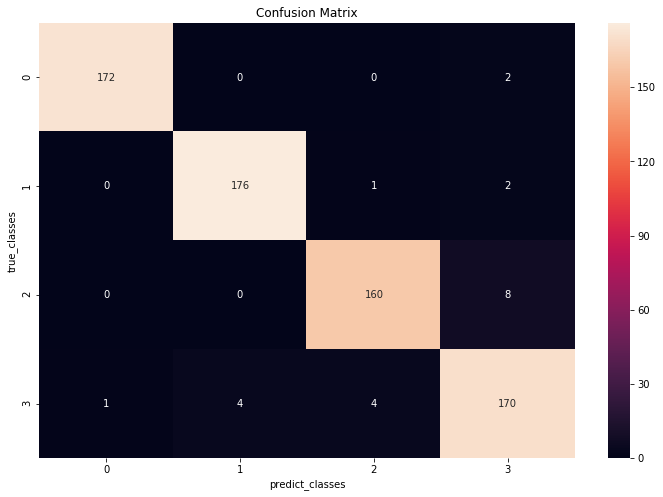

処理時間：13.138189792633057[s]


,text,true_label,pre_label,prediction
0,【Sports Watch】今井メロ、自身のブログで結婚＆出産を報告,スポーツ,ライフ,0.999887
1,【Sports Watch】村主千香が疾患を告白も、「元気いっぱいです」,スポーツ,ライフ,0.998767
2,あなただけのオリジナルダンス作成！ Twitter:Facebook連動コンテンツ「重...,IT,映画,0.995139
3,北川景子さんが美しさの秘密を語る！NEX-F3 スペシャルコンテンツ「with α」が...,IT,ライフ,1.000000
4,揃いの色や柄、オリジナルプリントで一体感！ポロシャツのプロが運営するユニフォームタウン,IT,ライフ,0.565781
5,“家族愛”の優しい雨が降り注ぐ『おおかみこどもの雨と雪』,映画,ライフ,0.969547
6,「20代よりも30代の方が楽しい」広末涼子の“可愛さ”のヒミツ,映画,ライフ,0.977075
7,【GOGW映画 恋人編】 ゾンビによるゾンビのための純愛映画 『ゾンビ・ヘッズ...,映画,ライフ,0.978226
8,かわいいのは綾瀬はるかだけじゃない！ 『映画 ひみつのアッコちゃん』の“こだわり”,映画,ライフ,0.900072
9,インタビュー：MEGUMI＆西川史子＆重盛さと美「地上波では出来ないことしかやってない」,映画,ライフ,0.959219


In [28]:
MLP_dmpv(A_index_c[4], B_index_c[4], C_index_c[4], D_index_c[4], E_index_c[4], F_index_c[4], x_size, p=4)

# dbow

In [29]:
def MLP_dbow(x_test, x_train, y_test, y_train, z_test, z_train, x_size, p):
    MLP_model = Sequential()
    # MLPモデル構造を定義 --- (*5)
    MLP_model.add(Dense(128, activation='relu', input_shape=(x_size,)))
    MLP_model.add(Dropout(0.2))
    MLP_model.add(Dense(128, activation='relu'))
    MLP_model.add(Dropout(0.2))
    MLP_model.add(Dense(128, activation='relu'))
    MLP_model.add(Dropout(0.2))
    MLP_model.add(Dense(nb_classes, activation='softmax'))

    # モデルをコンパイル --- (*6)
    MLP_model.compile(
        loss='categorical_crossentropy',
        optimizer=RMSprop(),
        metrics=['accuracy'])
    
    t1 = time.time()                 #　開始
    # 学習を実行 --- (*7)
    hist = MLP_model.fit(x_train, y_train,
              batch_size=128,
              epochs=50,
              verbose=1,
              validation_data=(x_test, y_test))
    t2 = time.time()                #　終了
    
   # モデルの保存
    MLP_model.save('./model/skip_model_'+str(p)+'.hdf5')
    
    # モデルのロード
    model = load_model('./model/skip_model_'+str(p)+'.hdf5')
    #  混同行列
    predict_classes = model.predict_classes(x_test[1:10000]) ### 予測したラベルを取得
    true_classes = np.argmax(y_test[1:10000], 1) ### 実際のラベルを取得

    # 評価する ---(*8)
    score = model.evaluate(x_test, y_test, verbose=1)
    print('\n')
    print("正解率=", score[1], 'loss=', score[0])

    #  適応率, 再現率, F値
    rep = metrics.classification_report(true_classes, predict_classes)
    print(rep)

    # 学習の様子をグラフへ描画 --- (*10)
    # Accuracy
    plt.figure(figsize=(20, 5)) # figureの縦横の大きさ
    plt.subplot(1,2,1)
    plt.plot(hist.history['acc'])
    plt.plot(hist.history['val_acc'])
    plt.title('Accuracy')
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Loss')
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid()

    MLP_print_cmx(true_classes, predict_classes)

    # 経過時間を表示
    elapsed_time = t2-t1
    print(f"処理時間：{elapsed_time}"+"[s]")

    LABELS = ["スポーツ", "IT", "映画", "ライフ"]
    A=[]
    B=[]
    C=[]
    D=[]
    for i, j, k in zip(x_test, y_test, z_test):
        pre = MLP_model.predict(np.array([i]))[0]
        n = pre.argmax()
        l=np.where(j==1.0)
        if LABELS[n]!=LABELS[l[0][0]]:
            A.append(LABELS[n])
            B.append(pre[n])
            C.append(LABELS[l[0][0]])
            D.append(k)

    df=pd.DataFrame({'text':D,
                                     'true_label':C, 
                                    'pre_label':A,
                                    'prediction':B}
                                   )

    #     df.to_excel('Excel/TF-IDF_MLP_'+str(p)+'.xlsx', encoding='UTF-16')
    display(df)

In [30]:
data_s=pickle.load(open('/Users/Baron/Document/text_mining/Data/pickle/Doc2Vec/Body/d2v_body_dbow.pickle', "rb"))
z_s = data_s[0]   # 内容
y_s = data_s[1]   # ラベル
x_s = data_s[2]   # 特徴量
kf = KFold(n_splits=5, shuffle=True, random_state=0)
nb_classes = 4
# ラベルデータをone-hotベクトルに直す --- (*3)
y_s = keras.utils.np_utils.to_categorical(y_s, nb_classes)

# データの次元数
x_size = x_s[0].shape[0]
y_size = y_s[0].shape[0]

A_index_s=[]
B_index_s=[]
C_index_s=[]
D_index_s=[]
E_index_s=[]
F_index_s=[]

# 交差検証
for train, test in kf.split(x_s):
    A_s=np.empty((0,x_size), int)
    B_s=np.empty((0,x_size), int)
    C_s=np.empty((0,y_size), int)
    D_s=np.empty((0,y_size), int)
    E_s = []
    F_s = []
    for i in test:
        A_s = np.append(A_s, [x_s[i]], axis=0)           # x_test
        C_s = np.append(C_s, [y_s[i]], axis=0)           # y_test
        E_s.append(z_s[i])                                     # z_test
    A_index_s.append(A_s)
    C_index_s.append(C_s)
    E_index_s.append(E_s)
    for j in train:
        B_s = np.append(B_s, [x_s[j]], axis=0)            # x_train
        D_s = np.append(D_s, [y_s[j]], axis=0)           # y_train
        F_s.append(z_s[j])                                      # z_train
    B_index_s.append(B_s)
    D_index_s.append(D_s)
    F_index_s.append(F_s)

Train on 2806 samples, validate on 702 samples
Epoch 1/50
2806/2806 [==============================] - 3s 1ms/step - loss: 0.6203 - acc: 0.8161 - val_loss: 0.1569 - val_acc: 0.9430
Epoch 2/50
2806/2806 [==============================] - 0s 58us/step - loss: 0.1536 - acc: 0.9519 - val_loss: 0.1179 - val_acc: 0.9558
Epoch 3/50
2806/2806 [==============================] - 0s 56us/step - loss: 0.1047 - acc: 0.9654 - val_loss: 0.1132 - val_acc: 0.9573
Epoch 4/50
2806/2806 [==============================] - 0s 57us/step - loss: 0.0751 - acc: 0.9765 - val_loss: 0.1236 - val_acc: 0.9601
Epoch 5/50
2806/2806 [==============================] - 0s 52us/step - loss: 0.0660 - acc: 0.9772 - val_loss: 0.1253 - val_acc: 0.9615
Epoch 6/50
2806/2806 [==============================] - 0s 55us/step - loss: 0.0450 - acc: 0.9854 - val_loss: 0.1347 - val_acc: 0.9615
Epoch 7/50
2806/2806 [==============================] - 0s 59us/step - loss: 0.0341 - acc: 0.9886 - val_loss: 0.1559 - val_acc: 0.9544
Epoch 8/5

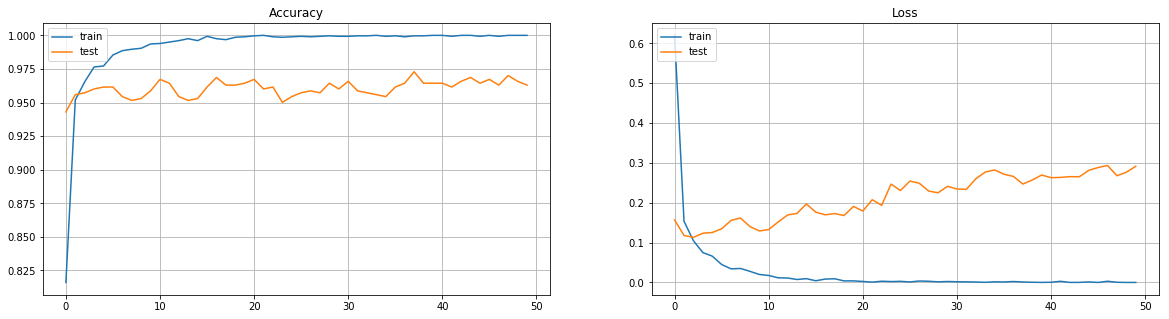

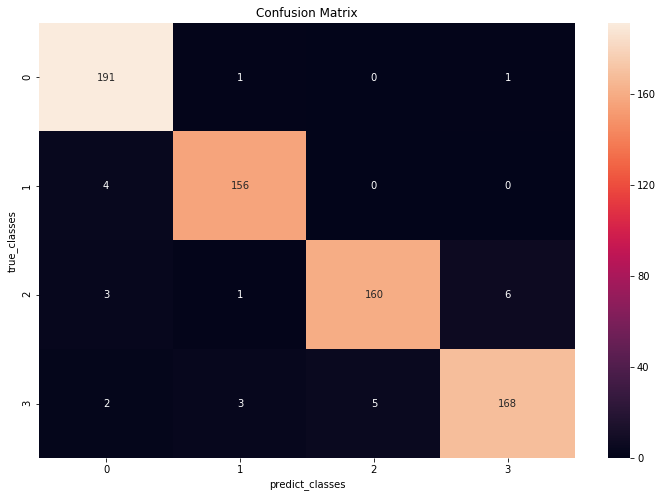

処理時間：11.645919799804688[s]


,text,true_label,pre_label,prediction
0,【Sports Watch／競馬】 あの名物珍名馬主・今年は役職シリーズ？,スポーツ,ライフ,0.996815
1,【Sports Watch／競馬】 迷走中!? 『うまプロ！』は何がしたいのか—,スポーツ,IT,0.999776
2,今年の夏は湘南とお台場へGo！ ニコニコ神社、夏の出張はお台場と海の家,IT,スポーツ,0.916370
3,個人スポンサー2万人達成！ロンドン五輪マラソン代表選手の藤原新選手,IT,スポーツ,0.999990
4,本日のGoogleロゴはやり投 Googleロゴがスポーツ関連画像に変化第七弾,IT,スポーツ,0.987436
5,本日のGoogleロゴはテーブルテニス Googleロゴがスポーツ関連画像に変化第四弾,IT,スポーツ,1.000000
6,“FBI行動分析課”に学べ！ 『クリミナル・マインド』流トラブルを生き抜くビジネス術,映画,ライフ,0.999841
7,【GOGW映画 友人編】崖っぷち女が、親友の座を掛けて完璧美女と友情バトル,映画,ライフ,0.975268
8,【編集部的映画批評】本格的なパフォーマンスを約束！ 新たな聖歌隊が感動を呼ぶ,映画,ライフ,0.925277
9,おバカすぎるヒロインもご愛嬌！ イケメン部長に癒される映画『ホタルノヒカリ』,映画,ライフ,0.783498


In [31]:
MLP_dbow(A_index_s[0], B_index_s[0], C_index_s[0], D_index_s[0], E_index_s[0], F_index_s[0], x_size, p=0)

Train on 2806 samples, validate on 702 samples
Epoch 1/50
2806/2806 [==============================] - 3s 1ms/step - loss: 0.6324 - acc: 0.8090 - val_loss: 0.1081 - val_acc: 0.9701
Epoch 2/50
2806/2806 [==============================] - 0s 62us/step - loss: 0.1643 - acc: 0.9498 - val_loss: 0.0741 - val_acc: 0.9744
Epoch 3/50
2806/2806 [==============================] - 0s 57us/step - loss: 0.1196 - acc: 0.9612 - val_loss: 0.0743 - val_acc: 0.9715
Epoch 4/50
2806/2806 [==============================] - 0s 55us/step - loss: 0.0863 - acc: 0.9736 - val_loss: 0.0626 - val_acc: 0.9744
Epoch 5/50
2806/2806 [==============================] - 0s 54us/step - loss: 0.0732 - acc: 0.9729 - val_loss: 0.0709 - val_acc: 0.9758
Epoch 6/50
2806/2806 [==============================] - 0s 49us/step - loss: 0.0498 - acc: 0.9847 - val_loss: 0.0710 - val_acc: 0.9701
Epoch 7/50
2806/2806 [==============================] - 0s 55us/step - loss: 0.0453 - acc: 0.9868 - val_loss: 0.0712 - val_acc: 0.9744
Epoch 8/5

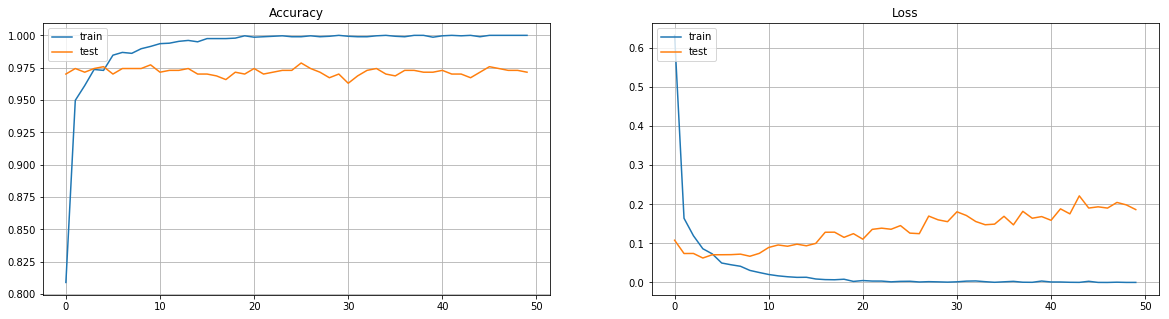

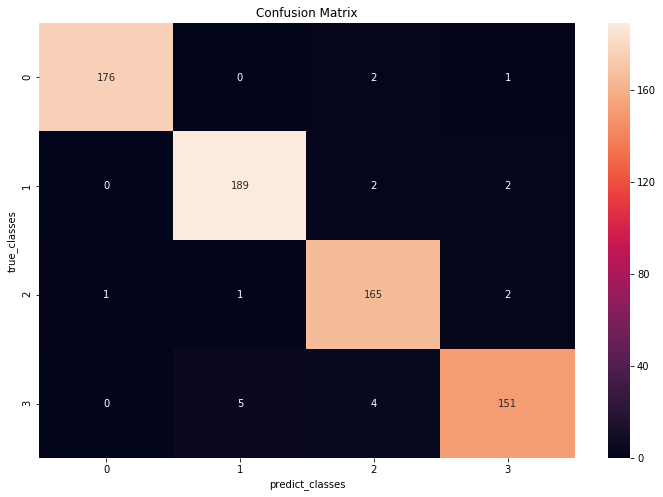

処理時間：11.358057022094727[s]


,text,true_label,pre_label,prediction
0,もう一つのユーロ2012 美女ばかりの観客席には選手の彼女も!?,スポーツ,映画,0.999765
1,イギリス中が熱狂したキュートすぎる陸上界の女王,スポーツ,映画,0.682228
2,長谷部誠、印税を全額被災地に寄付,スポーツ,ライフ,0.852291
3,Webで認知症チェックができる！ 日本初の認知機能チェックサービス「脳測」正式公開,IT,ライフ,0.999996
4,全国21店舗で配信開始！ ドスパラが9月より店内放送型情報番組を開始,IT,映画,0.975836
5,夏と言えば朝顔！ 小学生時代を思い起こさせるアサガオ観察日記ツイート,IT,ライフ,0.764866
6,懐かしのヒーローが続々！ 名アニメーターが描くヒーローイラストが話題に,IT,映画,0.812526
7,【いちおう妖ヶ劇場】第5話：妖怪集まりゃ、メジャーなんて目じゃーないの巻,映画,スポーツ,0.999491
8,原発が日本にとって必要なのか、そうではないのか問う,映画,IT,0.999993
9,恋人に会うために脱獄した、一途な“天才犯罪者”,映画,ライフ,0.947148


In [32]:
MLP_dbow(A_index_s[1], B_index_s[1], C_index_s[1], D_index_s[1], E_index_s[1], F_index_s[1], x_size, p=1)

Train on 2806 samples, validate on 702 samples
Epoch 1/50
2806/2806 [==============================] - 3s 1ms/step - loss: 0.6305 - acc: 0.8097 - val_loss: 0.1789 - val_acc: 0.9459
Epoch 2/50
2806/2806 [==============================] - 0s 51us/step - loss: 0.1465 - acc: 0.9515 - val_loss: 0.1308 - val_acc: 0.9615
Epoch 3/50
2806/2806 [==============================] - 0s 51us/step - loss: 0.0980 - acc: 0.9665 - val_loss: 0.1267 - val_acc: 0.9601
Epoch 4/50
2806/2806 [==============================] - 0s 50us/step - loss: 0.0799 - acc: 0.9729 - val_loss: 0.1289 - val_acc: 0.9558
Epoch 5/50
2806/2806 [==============================] - 0s 51us/step - loss: 0.0600 - acc: 0.9808 - val_loss: 0.1285 - val_acc: 0.9615
Epoch 6/50
2806/2806 [==============================] - 0s 54us/step - loss: 0.0450 - acc: 0.9843 - val_loss: 0.1252 - val_acc: 0.9630
Epoch 7/50
2806/2806 [==============================] - 0s 57us/step - loss: 0.0395 - acc: 0.9850 - val_loss: 0.1576 - val_acc: 0.9573
Epoch 8/5

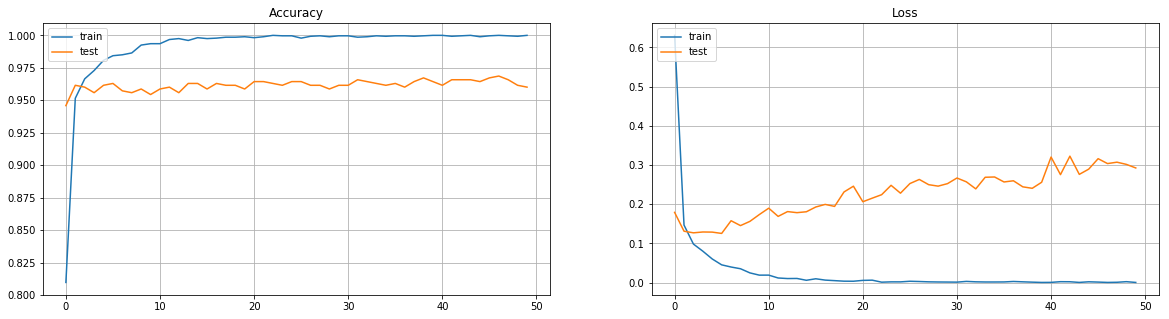

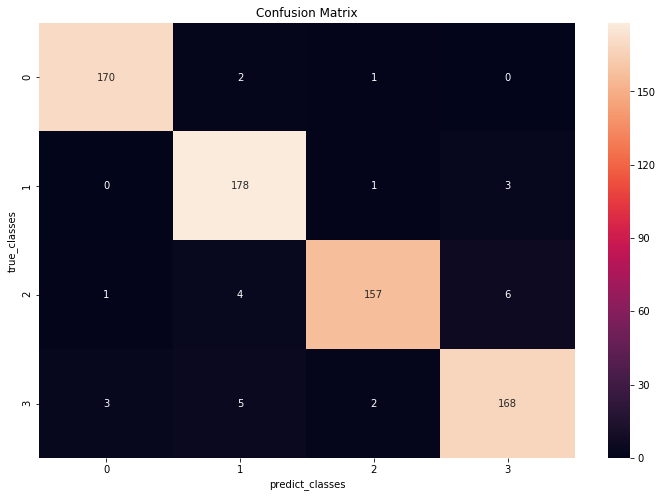

処理時間：11.645426034927368[s]


,text,true_label,pre_label,prediction
0,「これは可愛い」 佐々木希の後継、ブレイク必至の新EUROガール,スポーツ,映画,0.775717
1,【Sports Watch／競馬】 配当上乗せの「JRAプレミアムレース」ではこの馬券を買え！,スポーツ,IT,1.000000
2,注目度急上昇、可憐で知的な美女拳士＝栗田佳織とは,スポーツ,IT,0.562917
3,カワイイは正義！ おかもとまりさんのカワイすぎる顔真似メイキングが反則過ぎる,IT,ライフ,0.861199
4,大人気Ultrabookが作れる！ 親子で体験!! デル パソコン組み立て教室5回目...,IT,ライフ,1.000000
5,愛される英王子 裸で敬礼！ ハリー英国王子に対する英国軍人の大いなる愛,IT,映画,0.998820
6,細かな違いや使用感がわかる！ありそうでなかった白髪染め体験記サイト,IT,ライフ,0.979258
7,『バック・トゥ・ザ・フューチャー』に登場するデロリアン、世界30台限定で販売,映画,IT,1.000000
8,【編集部的映画批評】冴えない中年がチョイ悪オヤジに変身、人の数だけ異なる“幸せ”の形,映画,ライフ,0.999003
9,【編集部的映画批評】最高にポップな監禁拷問地獄へようこそ 『ラブド・ワンズ』,映画,ライフ,0.999994


In [33]:
MLP_dbow(A_index_s[2], B_index_s[2], C_index_s[2], D_index_s[2], E_index_s[2], F_index_s[2], x_size, p=2)

Train on 2807 samples, validate on 701 samples
Epoch 1/50
2807/2807 [==============================] - 4s 1ms/step - loss: 0.6217 - acc: 0.8137 - val_loss: 0.1470 - val_acc: 0.9515
Epoch 2/50
2807/2807 [==============================] - 0s 51us/step - loss: 0.1431 - acc: 0.9555 - val_loss: 0.1001 - val_acc: 0.9629
Epoch 3/50
2807/2807 [==============================] - 0s 57us/step - loss: 0.1044 - acc: 0.9633 - val_loss: 0.0935 - val_acc: 0.9700
Epoch 4/50
2807/2807 [==============================] - 0s 75us/step - loss: 0.0780 - acc: 0.9747 - val_loss: 0.1004 - val_acc: 0.9658
Epoch 5/50
2807/2807 [==============================] - 0s 63us/step - loss: 0.0630 - acc: 0.9797 - val_loss: 0.0898 - val_acc: 0.9729
Epoch 6/50
2807/2807 [==============================] - 0s 61us/step - loss: 0.0441 - acc: 0.9861 - val_loss: 0.0849 - val_acc: 0.9772
Epoch 7/50
2807/2807 [==============================] - 0s 60us/step - loss: 0.0354 - acc: 0.9904 - val_loss: 0.1011 - val_acc: 0.9729
Epoch 8/5

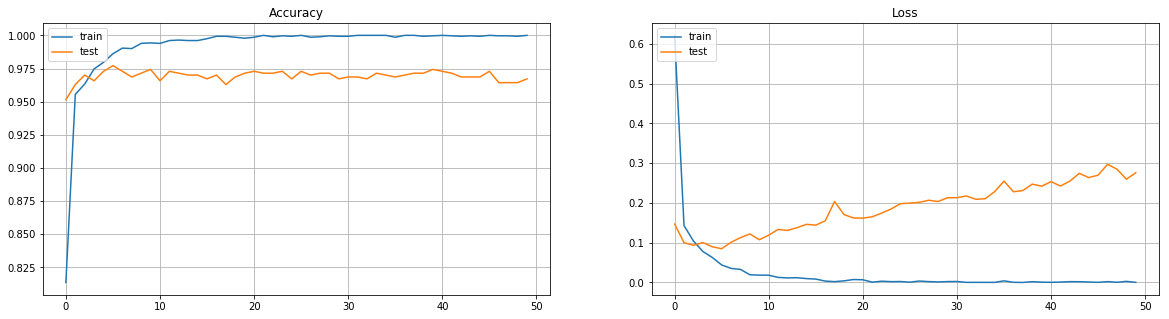

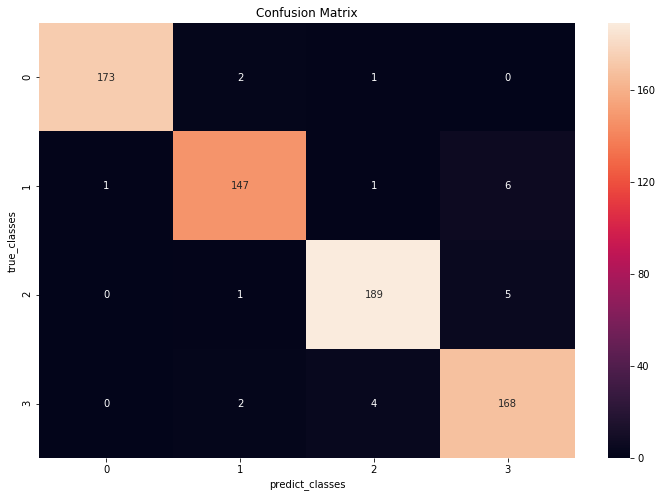

処理時間：12.579276084899902[s]


,text,true_label,pre_label,prediction
0,【Sports Watch】W杯ツアー業者が音信不通、被害額は1500万円超!?,スポーツ,IT,0.999992
1,【Sports Watch】長谷川穂積、最愛の母が死去 “もし一つだけ願いが叶うなら・・・”,スポーツ,映画,0.999920
2,開会式は「五輪のマークが出てきて、それがとんでもないことになる」!?,スポーツ,IT,0.980563
3,117万2132件の動画中最高の1本！ニコニコ動画「第4回動画アワード」グランプリ作品決定,IT,映画,0.992100
4,コンプガチャ廃止決定！ 結局は堂々巡り？ 今後一体どうなる？,IT,ライフ,0.999149
5,何これやばい！ウマそう！ ホントに学食？ 最近の学食は驚きの豪華メニュー,IT,ライフ,1.000000
6,同じ趣味の人を紹介し合おう Facebookで広げる友達の輪【知っ得！虎の巻】,IT,ライフ,0.999991
7,夏のボーナス金額は増！ ただし商品の購入に充てる割合は大幅減,IT,ライフ,1.000000
8,次世代22nmプロセッサー対応「Z77X-UD5H」マザーボードの魅力をさぐる,IT,ライフ,0.978002
9,毅然とした態度で臨んでいく！グリー田中社長が訴訟の判決にコメント,IT,スポーツ,0.926522


In [34]:
MLP_dbow(A_index_s[3], B_index_s[3], C_index_s[3], D_index_s[3], E_index_s[3], F_index_s[3], x_size, p=3)

Train on 2807 samples, validate on 701 samples
Epoch 1/50
2807/2807 [==============================] - 4s 1ms/step - loss: 0.6245 - acc: 0.8037 - val_loss: 0.1299 - val_acc: 0.9658
Epoch 2/50
2807/2807 [==============================] - 0s 67us/step - loss: 0.1472 - acc: 0.9526 - val_loss: 0.0891 - val_acc: 0.9729
Epoch 3/50
2807/2807 [==============================] - 0s 83us/step - loss: 0.1132 - acc: 0.9626 - val_loss: 0.0845 - val_acc: 0.9743
Epoch 4/50
2807/2807 [==============================] - 0s 87us/step - loss: 0.0872 - acc: 0.9726 - val_loss: 0.0790 - val_acc: 0.9757
Epoch 5/50
2807/2807 [==============================] - 0s 79us/step - loss: 0.0686 - acc: 0.9761 - val_loss: 0.0832 - val_acc: 0.9686
Epoch 6/50
2807/2807 [==============================] - 0s 79us/step - loss: 0.0581 - acc: 0.9800 - val_loss: 0.0833 - val_acc: 0.9786
Epoch 7/50
2807/2807 [==============================] - 0s 63us/step - loss: 0.0433 - acc: 0.9857 - val_loss: 0.0765 - val_acc: 0.9829
Epoch 8/5

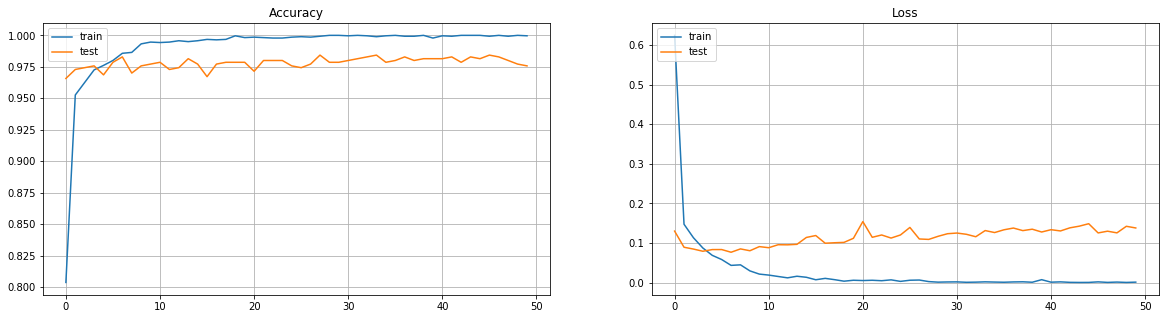

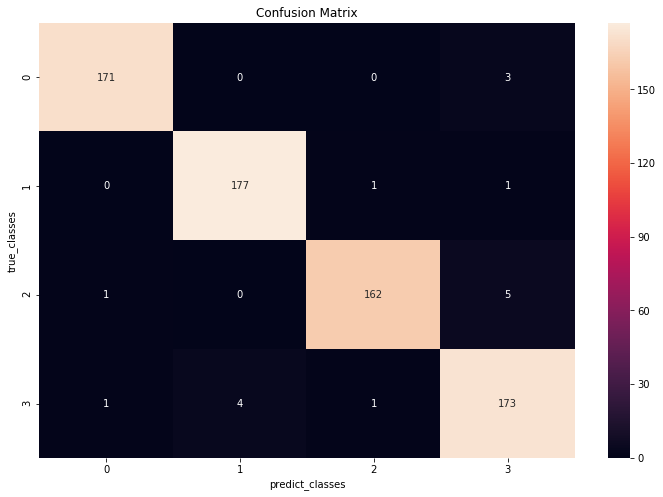

処理時間：12.628656148910522[s]


,text,true_label,pre_label,prediction
0,【Sports Watch】今井メロ、自身のブログで結婚＆出産を報告,スポーツ,ライフ,0.999721
1,【Sports Watch】村主千香が疾患を告白も、「元気いっぱいです」,スポーツ,ライフ,0.996544
2,健介の一番弟子＝中嶋勝彦が婚約発表。北斗は″あるエピソード″を明かす,スポーツ,ライフ,0.519681
3,あなただけのオリジナルダンス作成！ Twitter:Facebook連動コンテンツ「重...,IT,映画,0.619995
4,北川景子さんが美しさの秘密を語る！NEX-F3 スペシャルコンテンツ「with α」が...,IT,ライフ,1.000000
5,“家族愛”の優しい雨が降り注ぐ『おおかみこどもの雨と雪』,映画,ライフ,0.759563
6,【2012年先取り映画vol.5】名もなきメイドたちの声を集め、時代を変えた一冊の「ストーリー」,映画,ライフ,0.632864
7,【GOGW映画 恋人編】 ゾンビによるゾンビのための純愛映画 『ゾンビ・ヘッズ...,映画,ライフ,0.989026
8,インタビュー：ミシェル・ウィリアムズ「マリリンのイメージは虚像」,映画,ライフ,0.696832
9,インタビュー：有森裕子「お互いに嘘は無い、それは確かなこと」,映画,スポーツ,0.989694


In [35]:
MLP_dbow(A_index_s[4], B_index_s[4], C_index_s[4], D_index_s[4], E_index_s[4], F_index_s[4], x_size, p=4)

# グリッドサーチ

In [36]:
# # コピー2
# def MLP_grid(activation, optimizer, out_dim):
#     MLP_model = Sequential()    
#     # MLPモデル構造を定義 --- (*5) 
#     MLP_model.add(Dense(out_dim, activation=activation, input_shape=(x_size,)))
#     MLP_model.add(Dropout(0.2))
#     MLP_model.add(Dense(out_dim, activation=activation))
#     MLP_model.add(Dropout(0.2))
#     MLP_model.add(Dense(out_dim, activation=activation))
#     MLP_model.add(Dropout(0.2))
#     #  出力層
#     MLP_model.add(Dense(nb_classes, activation='softmax'))

#     # モデルをコンパイル --- (*6)
#     MLP_model.compile(
#         loss='categorical_crossentropy',
#         optimizer=optimizer,
#         metrics=['accuracy'])
#     return MLP_model    

# # データを返す関数
# def data(i):
#     # x_train, y_train, x_test, y_test
#     return B_index[i], D_index[i], A_index[i], C_index[i]

In [37]:
# activation = ["relu"]
# optimizer = ["rmsprop"]
# out_dim=[128]
# nb_epoch = [30]
# batch_size = [128]
# model = KerasClassifier(build_fn=MLP_grid, verbose=0)
# param_grid = dict(activation=activation, 
#                                 optimizer=optimizer, 
#                                 out_dim=out_dim, 
#                                 nb_epoch=nb_epoch, 
#                                 batch_size=batch_size)
# grid = GridSearchCV(estimator=model, param_grid=param_grid)

In [38]:
# # Data[0]:x_train, Data[1]:y_train, Data[2]:x_test, Data[3]:y_test
# grid_result = grid.fit(data(i=0)[0], data(i=0)[1])

In [39]:
# print (grid_result.best_score_)
# print (grid_result.best_params_)

In [40]:
# clf = grid_result.best_estimator_
# for t in range(5):
#     accuracy = clf.score(data(i=0)[i], data(i=0)[i])
#     print("\nAccuracy: %.2f" % (accuracy))